# Sales Data Forecast

This task is to build a ML model to daily forecast Quarterly Sales Growth YoY for various companies. I tried three methods: Vector autoregression (VAR, Baseline model), Long-short term memory (LSTM) and catboost, to predict the daily Sales Growth YoY and compare the results with the benchmark, consensus estimation, based on the distance to actual values.

**Evaluation Metric:**

The evaluation metric is taken as a root-mean-squared deviation (RMSE). It is a non-negative value and measures the distance between the true value and predicted value. Most of the company RMSE are between 0 and 0.08. The median of it is 0.035409 which is a relatively small number. The consensus estimation method is acceptable.

**Model Selection:**

The problem here is to estimate the quarterly sales growth YoY for each company in the next public financial report. We assume the market is efficient, which means all the historical and public information could be reflected in current data. Therefore we need a model that could capture the influence of past values of itself and also other companies. 

The most commonly used method for multivariate time series forecasting is **Vector autoregression (VAR)**. In this model, each variable is a linear function of the past values of itself and the past values of all the other variables. The neural-network type model like **LSTM** is able to almost seamlessly model problems with multiple input variables and provides benefits in time series forecasting comparing to classical linear methods which can be difficult to adapt to multivariate or multiple input forecasting problems. Gradient Boosted Decision Trees are the top performers on Kaggle competitions and in widespread use in the industry. We notice categorical features play a large role in the provided dataset so **CatBoost** is chosen from the Gradient Boost family. CatBoost has the flexibility of giving indices of categorical columns so that it can be encoded as one-hot encoding using one_hot_max_size (Use one-hot encoding for all features with the number of different values less than or equal to the given parameter value). 

**Comparison**

The predictions for company 15 is visualized as an example. LSTM and catBoost perform better than benchmark and VAR model.
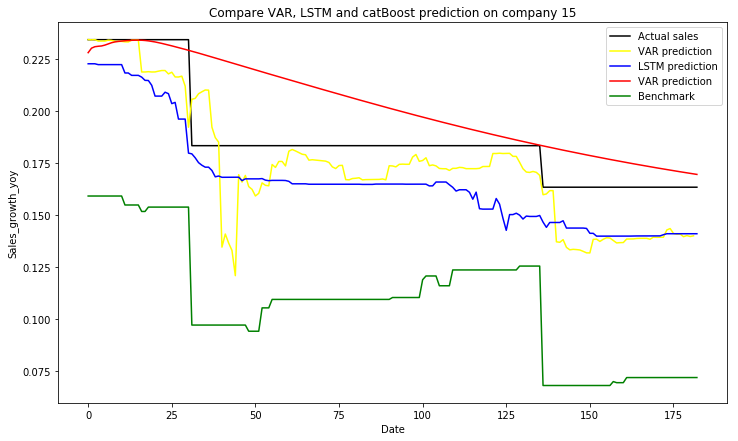

|                                                     | Consensus | VAR              | LSTM                                                         | catBoost |
| --------------------------------------------------- | --------- | ---------------- | ------------------------------------------------------------ | -------- |
| Median RMSE                                         | 0.036     | 0.061            | 0.044                                                        | 0.012    |
| No. of companies that RMSE is better than benchmark | NA        | 36.4%            | 83.6%                                                        | NA       |
| Training time                                       | NA        | Short | Long | Short     |
| Can handle the missing value in training            | NA        | No               | Yes                                                          | Yes      |


**Prediction**

Make prediction using catBoost trained model with the imputed dataset. The result is saved in cb_forecast.csv. (NaN means the dates for this company are not available in raw data.)

**Summary**

* In this task, catBoost achieves the best performance according to RMSE comparison.
* The traditional time series models such as AR or ARIMA are essentially linear models. In contrast, RNN or LSTM is the nonlinear time series model which are able to capture the nonlinearity by learning from the data. LSTM can also handle missing value by adding a masking layer without actual imputation. However, the training time is much longer than other methods as we need to model every single company.
* The VAR performs worst among the methods and missing value imputation does significantly impact its results. As it is a linear model, it is more intuitive to look at its parameter estimation and figure out how the future value is influenced by the past.

**Future work:**

* As for missing value matters, there should better imputation methods to enhance the performance of catboost and VAR.
* Finetuning the models:More structured LSTM may be considered since the hidden layers in the proposed LSTM model only contains a masking layer and a LSTM layer.
* As the VAR model only includes the correlations among the variables, it may be useful to incorporate causality effects as an improvement.
* Include more features, such as sales from correlated companies for catBoost.

In [229]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import Counter
import scipy.stats as ss
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
import time
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 
plotly.tools.set_credentials_file(username='manxin0821', api_key='1gtqp2YmzDjUbm8CFvw9')
import warnings
warnings.filterwarnings('ignore')

## Data Exploration
Before we go into more complicated work, first we have to explore our dataset. Let's have a quick look at our features.

In [59]:
# Read in the data 
df = pd.read_csv('./data/forecasting_dataset.csv')
df['date'] = pd.to_datetime(df['date'],format='%Y/%m/%d')
df['filing_date'] = pd.to_datetime(df['filing_date'],format='%Y/%m/%d')
df['period_end_date'] = pd.to_datetime(df['period_end_date'],format='%Y/%m/%d')
data = df.replace([np.inf, -np.inf], np.nan)
data.head()

,date,company_id,sector_id,sales_growth_yoy,consensus_sales_growth_yoy,filing_date,period_end_date
0,2014-01-01,1,24,0.035030,0.017983,2014-02-04,2014-01-03
1,2014-01-01,2,21,-0.021529,-0.012229,2014-02-04,2013-12-31
2,2014-01-01,3,7,0.036553,0.040050,2014-02-13,2013-12-31
3,2014-01-01,4,6,0.074647,0.078425,2014-01-15,2013-12-31
4,2014-01-01,5,22,-0.034897,-0.030860,2014-02-24,2013-12-31


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412467 entries, 0 to 412466
Data columns (total 7 columns):
date                          412467 non-null datetime64[ns]
company_id                    412467 non-null int64
sector_id                     412467 non-null int64
sales_growth_yoy              397155 non-null float64
consensus_sales_growth_yoy    398957 non-null float64
filing_date                   409671 non-null datetime64[ns]
period_end_date               411038 non-null datetime64[ns]
dtypes: datetime64[ns](3), float64(2), int64(2)
memory usage: 22.0 MB


There are around 4% data are missing values. Let's drop these values firstly and take a look at the analysis of the rest data.

In [4]:
df_na=df.dropna()
df_na.describe()

,company_id,sector_id,sales_growth_yoy,consensus_sales_growth_yoy
count,395557.000000,395557.000000,395557.000000,395557.000000
mean,118.964496,14.612645,9.740422,11.735858
std,69.953329,7.569774,628.533695,759.905911
min,1.000000,0.000000,-1.000000,-1.000000
25%,59.000000,8.000000,-0.019661,-0.010241
50%,117.000000,16.000000,0.052679,0.048568
75%,179.000000,22.000000,0.134245,0.122382
max,250.000000,26.000000,41443.444444,52556.555556


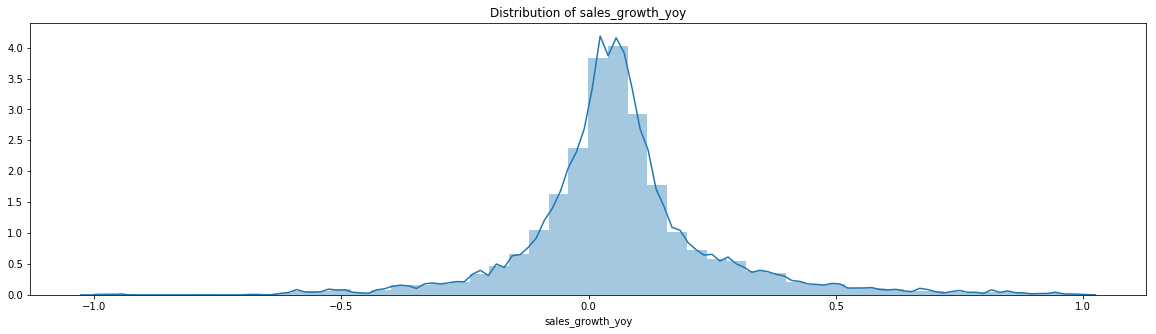

In [10]:
plt.clf()
plt.figure(figsize=(20,5))
plt.title("Distribution of sales_growth_yoy")
ax = sns.distplot(df_na[df_na['sales_growth_yoy']<1]['sales_growth_yoy'])
plt.show()

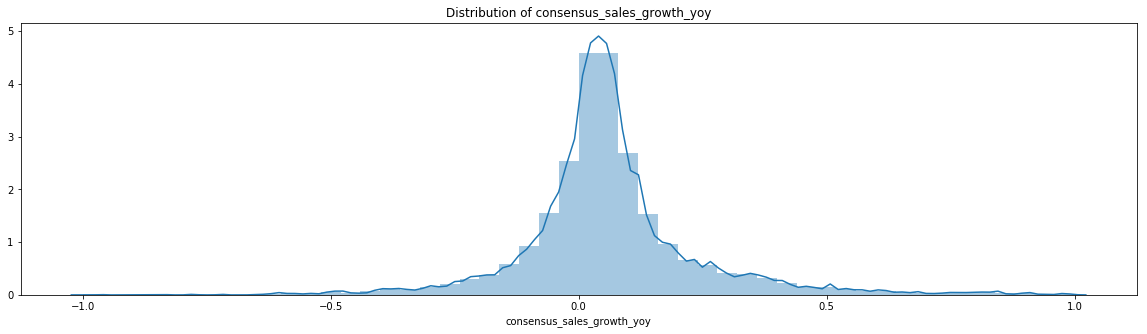

In [11]:
plt.clf()
plt.figure(figsize=(20,5))
plt.title("Distribution of consensus_sales_growth_yoy")
ax = sns.distplot(df_na[df_na['consensus_sales_growth_yoy']<1]['consensus_sales_growth_yoy'])
plt.show()

As we can see only sales growth YoY and consensus sales growth are continuous variables and others are categorical data. Therefore I choose catBoost, which could handle categorical inputs better than Xgboost. There are 250 companies within 27 sectors in this dataset. Over 50% of the sales/consensus sales growth rates are between -0.02 and 0.13 and the median number is around 0 so I will fill the missing values with 0.05 later. We notice that extreme values (eg. 41443.44) exist in the dataset but it is consistent with the consensus estimation. So I keep it in the dataset and does not treat it as an outlier.

Now let's build sales growth YoY and consensus sales growth YoY table to have a better exploration for each company.

In [289]:
# build date vs sales YoY and consensus_sales table.
sales = []
consensus_sales=[]

c_id = sorted(set(data.company_id))
for c in c_id:
    sales.append(data[data.company_id == c]['sales_growth_yoy'].values)
    consensus_sales.append(data[data.company_id == c]['consensus_sales_growth_yoy'].values)
    
sales_df = pd.DataFrame(sales).transpose()
sales_df.columns = c_id
sales_df.index = df[df.company_id==1]['date']
sales_df = sales_df.replace([np.inf, -np.inf], np.nan)

consensus_sales_df = pd.DataFrame(consensus_sales).transpose()
consensus_sales_df.columns = c_id
consensus_sales_df.index = df[df.company_id==1]['date']
consensus_sales_df = consensus_sales_df.replace([np.inf, -np.inf], np.nan)

sales_df=sales_df.replace([np.inf, -np.inf], np.nan)

sales_df.head()

,1,2,3,4,5,6,7,8,9,10,...,241,242,243,244,245,246,247,248,249,250
date,,,,,,,,,,,,,,,,,,,,,
01/01/2014,0.03503,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.512104,0.079755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02/01/2014,0.03503,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.512104,0.079755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03/01/2014,0.03503,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.512104,0.079755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04/01/2014,0.03503,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.512104,0.079755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05/01/2014,0.03503,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.512104,0.079755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
consensus_sales_df.head()

,1,2,3,4,5,6,7,8,9,10,...,241,242,243,244,245,246,247,248,249,250
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0.017983,-0.012229,0.04005,0.078425,-0.03086,-0.014393,0.085774,0.047812,-0.118755,0.020603,...,0.409919,0.116365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-02,0.017983,-0.012229,0.04005,0.078425,-0.03086,-0.014393,0.085774,0.049964,-0.118755,0.020603,...,0.409919,0.116365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,0.017983,-0.012229,0.04005,0.077039,-0.03086,-0.014393,0.085774,0.049964,-0.118755,0.020603,...,0.409919,0.116365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.017983,-0.012229,0.04005,0.077039,-0.03086,-0.014393,0.085774,0.049964,-0.118755,0.020603,...,0.409919,0.129928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.017983,-0.012229,0.04005,0.077039,-0.03086,-0.014393,0.085774,0.049964,-0.118755,0.020603,...,0.409919,0.129928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# plot random 3 companies
plt.clf()

data_plot = [
    go.Scatter(
        x=sales_df.index,
        y=sales_df[1],
        name='company 1'),
    go.Scatter(
        x=sales_df.index,
        y=sales_df[92],
        name='company 92'),
    go.Scatter(
        x=sales_df.index,
        y=sales_df[132],
        name='company 132')
]

layout = go.Layout(
    title='Quarterly sales_growth_yoy by company',
    xaxis=dict(
        title='Date',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Sales_growth_yoy',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
fig = go.Figure(data=data_plot, layout=layout)
py.iplot(fig)

In [15]:
plt.clf()

data_plot = [
    go.Scatter(
        x=sales_df.index,
        y=sales_df[1],
        name='sales_growth_yoy'
    ),
    go.Scatter(
        x=consensus_sales_df.index,
        y=consensus_sales_df[1],
        name='consensus_sales_growth_yoy')
]

layout = go.Layout(
    title='Quarterly sales_growth_yoy vs consensus_sales_yoy by company',
    xaxis=dict(
        title='Date',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='consensus_sales_growth_yoy',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
fig = go.Figure(data=data_plot, layout=layout)
py.iplot(fig)

In [16]:
# find the index list for companies with missing value, with missing value more than 80% and with missing value less than 80%
missing_perc = sales_df.isnull().sum()/len(sales_df.index)
indx_nomissing=missing_perc[missing_perc==0].index.tolist()
indx_missing_m0=missing_perc[missing_perc>0].index.tolist()
indx_missing_m80 =missing_perc[missing_perc>0.8].index.tolist()
indx_missing_l80=list(set(indx_missing_m0) - set(indx_missing_m80))

print(len(indx_missing_m0))
print(len(indx_missing_m80))

79
11


250 companies are recorded in the provided dataset between 2014/1/1 to 2018/12/31 (1826 dates). 79 companies have missing values and there are 11 companies have missing values more than 80%.

From the plot, we can see the actual Sales Growth YoY rates are only updated four times per year on the one day after the filing dates. Therefore the sales_growth_yoy rates between two filling_date should be constant. The consensus data follows the actual sales data trend while the consensus data could change between two filling date. Take one row in the provided data as an example,

| date      | company_id | sector_id | sales_growth_yoy | consensus_sales_growth_yoy | filling_date | period_end_date |
| --------- | ---------- | --------- | ---------------- | -------------------------- | ------------ | --------------- |
| 2014/1/28 | 206        | 22        | 0.16             | 0.10                       | 2014/1/30    | 2013/12/31      |

this means on the date of 2014/1/28, the actual sales_growth_yoy for the quarter of 2013/10/1 to 2013/12/31 of company 206 is 0.16, published on last filing date before 2014/1/30. Each company may have different filing dates every year while the reports are scheduled to be published quarterly per year. 

We could also see there is no significant trend & seasonality in these time series data.

In [17]:
# build company vs sector table.
sector = []
sector_0=[]
sector_1=[]
c_id = sorted(set(data.company_id))
for c in c_id:
    sector.append(data[data.company_id == c]['sector_id'].values)
    sector_0.append(list(set(data[data.company_id == c]['sector_id'].values)))
    sector_1.append(list(set(data[data.company_id == c]['sector_id'].values))[0])
sector_df = pd.DataFrame(sector)
sector_df.index = c_id
sector_df.head()
sector_0_df = pd.DataFrame(sector_0)
sector_0_df.index = c_id
sector_1_df = pd.DataFrame(sector_1)
sector_1_df.index = c_id

In [18]:
from collections import defaultdict

sector_tuple=[]
for i in range(len(sector_1_df.index)):
    sector_tuple.append(tuple((sector_1_df[0].iloc[i],sector_1_df.index[i])))

sector_company = {}
for k,v in sector_tuple:
    sector_company.setdefault(k,[]).append(v)
    
sector_company_no = {}
for k in sector_company:
    sector_company_no[k]=len(sector_company[k])
    
sector_company.items()

dict_items([(24, [1, 81, 83, 90, 134, 164, 187, 230, 235, 243, 245]), (21, [2, 24, 32, 139, 167, 175, 182, 196, 205, 248]), (7, [3, 59, 77, 159, 169, 172]), (6, [4, 9, 15, 19, 27, 35, 38, 49, 63, 65, 69, 84, 92, 106, 121, 149, 173, 176, 197, 200, 209]), (22, [5, 88, 109, 116, 117, 128, 130, 156, 185, 190, 206, 218, 223, 227, 228]), (19, [6, 13, 16, 17, 26, 41, 75, 82, 89, 96, 161, 162, 213]), (3, [7, 31, 67, 85, 195, 239]), (12, [8, 14, 25, 33, 40, 43, 50, 91, 108, 112, 115, 122, 123, 142, 151, 154, 165, 180, 193, 194, 215, 232]), (26, [10, 22, 28, 29, 46, 51, 53, 60, 62, 79, 186, 204]), (25, [11, 20, 57, 72, 136, 178, 220]), (8, [12, 21, 78, 133, 192, 214, 244]), (11, [18, 44, 45, 95, 100, 104, 124, 129, 183, 188, 191, 231, 236]), (0, [23, 52, 55, 119, 146, 147, 150, 170, 207]), (17, [30, 34, 48, 58, 66, 101, 111, 114, 140, 148, 157, 166, 168, 171, 174, 177, 201, 208, 216, 217, 219, 222, 224, 225, 226, 229, 237]), (1, [36]), (18, [37, 73, 99, 125]), (15, [39, 42, 102]), (16, [47, 71, 

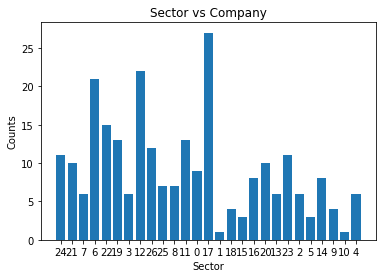

In [19]:
plt.clf()

plt.bar(range(len(sector_company_no)), sector_company_no.values(), align='center')
plt.xticks(range(len(sector_company_no)), sector_company_no.keys())
plt.title('Sector vs Company')
plt.xlabel('Sector')
plt.ylabel('Counts')

plt.show()

There are 27 sectors in the dataset with max 27 companies and min 1 companies in each sector. Let's plot the sales data in sector 5 and sector 15.

In [20]:
plt.clf()
data_plot = [
    go.Scatter(x=sales_df.index,y=sales_df[68],name='section5_company 68',marker = dict(color = 'rgba(255, 182, 193, .9)')),
    go.Scatter(x=sales_df.index,y=sales_df[70],name='section5_company 70',marker = dict(color = 'rgba(255, 182, 193, .9)')),
    go.Scatter(x=sales_df.index,y=sales_df[93],name='section5_company 93',marker = dict(color = 'rgba(255, 182, 193, .9)')),
    go.Scatter(x=sales_df.index,y=sales_df[39],name='section15_company 39',marker = dict(color = 'rgba(0, 182, 193, .9)')),
    go.Scatter(x=sales_df.index,y=sales_df[42],name='section15_company 42',marker = dict(color = 'rgba(0, 182, 193, .9)')),
    go.Scatter(x=sales_df.index,y=sales_df[105],name='section15_company 105',marker = dict(color = 'rgba(0, 182, 193, .9)'))
]

layout = go.Layout(
    title='Quarterly sales_growth_yoy by company',
    xaxis=dict(title='Date',titlefont=dict(family='Courier New, monospace',size=18,color='#7f7f7f')),
    yaxis=dict(title='Sales_growth_yoy',titlefont=dict(family='Courier New, monospace',size=18,color='#7f7f7f'))
)
fig = go.Figure(data=data_plot, layout=layout)
py.iplot(fig)

We could see the sales data is not necessary to be the same trend or shape for companies in the same sector.

In [22]:
# build functions for later analysis
def get_company_sector(company,sector_1_df):
    return sector_1_df[0].iloc[company-1]
def get_sector_company(sector,sector_company):
    return sector_company[sector]

## Missing Value

To prepare the input data for VAR and prediction, I tried two methods, MICE[1] and Linear Regression to impute the missing value for sales growth and consensus sales growth. I will compare the results based on the plot comparing with the original data and model results in later parts to decide which methods should be applied. I only applied the imputation methods to companies with missing value less than 80% drop the companies with missing value more than 80%. 

**Multiple Imputation by Chained Equations**
* Imputation: Impute the missing entries of the incomplete data sets m times. Note that imputed values are drawn from a distribution. Simulating random draws doesn’t include uncertainty in model parameters. Better approach is to use Markov Chain Monte Carlo (MCMC) simulation. This step results in m complete data sets.
* Analysis: Analyze each of the m completed data sets.
* Pooling: Integrate the m analysis results into a final result

**Linear Regression**

To begin, several predictors of the variable with missing values are identified using a correlation matrix. The best predictor (no missing value) is selected and used as independent variables in a regression equation. The variable with missing data is used as the dependent variable. Cases with complete data for the predictor variables are used to generate the regression equation; the equation is then used to predict missing values for incomplete cases.

*[1] Azur M. J et al. Multiple Imputation by Chained Equations: what is it and how does it work?. Int J Methods Psych Res. 2011. 20(1): 40–49.*

In [24]:
# find most correlated companies without missing value
def get_corr_company(corr,num,q_indx_nomissing):
    corr_company=defaultdict(list)   
    for i in range(len(corr)):
        corr_list=corr[i+1].tolist()
        rank_index=list(len(corr_list)-ss.rankdata(corr_list, method='ordinal').astype(int))
        
        #index removing diagonal company and companies with missing value
        nomissing_index=list(set(q_indx_nomissing)-set([i+1]))
        
        # check if the correlated companies having no missing value
        for j in range(len(corr_list)):
            if len(corr_company[i+1])<=num-1 and j+1 in rank_index and rank_index.index(j+1)+1 in nomissing_index:
                corr_company[i+1].append(rank_index.index(j+1)+1)

    return corr_company

In [290]:
#test on company 7
corr=sales_df.corr().abs()
consensus_corr=consensus_sales_df.corr().abs()
num=3
corr_company=get_corr_company(corr,num,indx_nomissing)
print('Top 3 most no missing value correlated companies with company 7:', corr_company[7])

Top 3 most no missing value correlated companies with company 7: [160, 207, 21]


In [28]:
from fancyimpute import IterativeImputer

def estimate_by_mice(df):
    df_estimated_var = df.copy()
    
    n_imputations = 1
    res = []
    for i in range(n_imputations):
        imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=i)
        res.append(imputer.fit_transform(df))

    #df_estimated_var.loc[:, df.columns] = res[:][:]
    #return df_estimated_var
    return res

/Users/qinchengwei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [29]:
# impute by MICE
def impute_by_mice(df):
    df_estimated_var = df.copy()
    
    n_imputations = 1
    res = []
    for i in range(n_imputations):
        imputer = IterativeImputer(n_iter=5, sample_posterior=True, random_state=i)
        res.append(imputer.fit_transform(df))

    return res
def get_imputation_by_mice(y_company,sales_df_quarter,corr,q_indx_nomissing):
    corr_company=get_corr_company(corr,1,q_indx_nomissing)
    x_company=corr_company[y_company][0]
    y_list=sales_df_quarter[y_company].tolist()
    x_list=sales_df_quarter[x_company].tolist()
    
    # start the MICE training
    res=impute_by_mice(list(zip(x_list,y_list)))
    df_res=pd.DataFrame(res[0])
    
    return df_res[1]
def get_df_imputation_by_mice(sales_df_quarter,corr,q_indx_nomissing,q_indx_missing_l80,q_indx_missing_m80):
    # for companies with missing value less than 80%, impute by MICE
    res=sales_df_quarter.copy()
    for y_company in q_indx_missing_l80:
        # to check and make sure all original missing values are not replaced
        notnull_indx=res[res[y_company].notnull()].index
        res[y_company]=get_imputation_by_mice(y_company,sales_df_quarter,corr,q_indx_nomissing).values
        res[y_company][notnull_indx]=sales_df_quarter[y_company][notnull_indx]
  
    # drop companies with missing value more than 80%
    return res.drop(q_indx_missing_m80, axis=1)

In [30]:
df_imputation_by_mice_daily=get_df_imputation_by_mice(sales_df,corr,indx_nomissing,indx_missing_l80,indx_missing_m80)

In [291]:
consensus_df_imputation_by_mice_daily=get_df_imputation_by_mice(consensus_sales_df,consensus_corr,indx_nomissing,indx_missing_l80,indx_missing_m80)

In [368]:
#df_imputation_by_mice_daily.to_csv('./data/df_imputation_by_mice_daily.csv')

In [356]:
df_imputation_by_mice_daily

,1,2,3,4,5,6,7,8,9,10,...,238,239,240,241,242,243,244,246,247,248
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01,0.035030,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.804018,0.007742,-0.388364,0.512104,0.079755,0.021571,-0.092945,0.811002,-0.097472,0.122227
2014-01-02,0.035030,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.995403,-0.036572,-0.388364,0.512104,0.079755,-0.028568,-0.175580,0.864647,-0.104987,0.178256
2014-01-03,0.035030,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.570214,0.029572,-0.244111,0.512104,0.079755,-0.012877,-0.160027,0.845965,-0.103645,0.135964
2014-01-04,0.035030,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.935429,-0.050872,-0.277140,0.512104,0.079755,-0.081521,-0.147927,0.874353,-0.105217,0.147863
2014-01-05,0.035030,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.655769,-0.003074,-0.227840,0.512104,0.079755,-0.038073,-0.113636,0.908309,-0.071541,0.185522
2014-01-06,0.035030,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.745726,-0.028652,-0.287798,0.512104,0.079755,0.060719,-0.180682,0.846365,-0.106573,0.154756
2014-01-07,0.035030,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.872715,0.030969,-0.252173,0.512104,0.079755,-0.051254,-0.177188,0.866623,-0.079916,0.221474
2014-01-08,0.035030,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.580067,-0.020507,-0.271236,0.512104,0.079755,-0.079177,-0.208841,0.874131,-0.121429,0.214032
2014-01-09,0.035030,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.900851,-0.101327,-0.226799,0.512104,0.079755,-0.011137,-0.159186,0.819309,-0.103563,0.176817


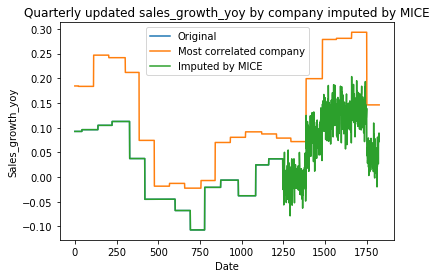

In [40]:
plt.plot(sales_df[7].values,label='Original')
plt.plot(sales_df[160].values,label='Most correlated company')
plt.plot(df_imputation_by_mice_daily[7].values,label='Imputed by MICE')

plt.title('Quarterly updated sales_growth_yoy by company imputed by MICE')
plt.xlabel('Date')
plt.ylabel('Sales_growth_yoy')
plt.legend()
plt.show()

In [255]:
#impute by regression
def get_imputation_by_lm(y_company,sales_df,corr,q_indx_nomissing):
    corr_company=get_corr_company(corr,1,q_indx_nomissing)
    x_company=corr_company[y_company][0]
    
    y_arr=sales_df[y_company].values
    x_arr=sales_df[x_company].values
    # find missing value index used to conduct regression and need be imputed
    reg_index=list(np.where(~np.isnan(y_arr))[0])
    nonreg_index=list(np.where(np.isnan(y_arr))[0])
    # extract non missing value part for regression
    y_reg=y_arr[reg_index].reshape(-1,1)
    x_reg=x_arr[reg_index].reshape(-1,1)

    lm=LinearRegression().fit(x_reg,y_reg)
    y_pred = lm.predict(x_arr.reshape(-1,1))
    #replace non missing value in y_pred
    y_list = np.array(list(map(lambda x: x[0], y_pred)))
    y_list[reg_index]=y_arr[reg_index]
    
    return pd.Series(y_list)

def get_df_imputation_by_lm(sales_df_quarter,corr,q_indx_nomissing,q_indx_missing_l80,q_indx_missing_m80):
    # for companies with missing value less than 80%, impute by lm
    res=sales_df_quarter.copy()
    for y_company in q_indx_missing_l80:
        notnull_indx=res[res[y_company].notnull()].index
        
        res[y_company]=get_imputation_by_lm(y_company,sales_df_quarter,corr,q_indx_nomissing).values
        
        res[y_company][notnull_indx]=sales_df_quarter[y_company][notnull_indx]
    return res.drop(q_indx_missing_m80, axis=1)

In [258]:
df_imputation_by_lm_daily=get_df_imputation_by_lm(sales_df,corr,indx_nomissing,indx_missing_l80,indx_missing_m80)

In [292]:
consensus_df_imputation_by_lm_daily=get_df_imputation_by_lm(consensus_sales_df,consensus_corr,indx_nomissing,indx_missing_l80,indx_missing_m80)

In [ ]:
df_imputation_by_lm_daily.to_csv('./data/df_imputation_by_lm_daily.csv')

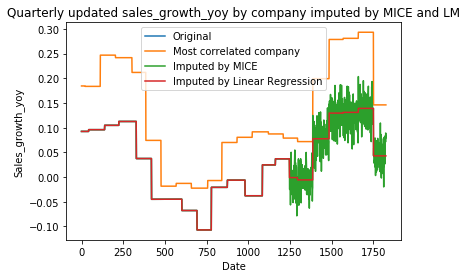

In [38]:
plt.plot(sales_df[7].values,label='Original')
plt.plot(sales_df[160].values,label='Most correlated company')
plt.plot(df_imputation_by_mice_daily[7].values,label='Imputed by MICE')
plt.plot(df_imputation_by_lm_daily[7].values,label='Imputed by Linear Regression')

plt.title('Quarterly updated sales_growth_yoy by company imputed by MICE and LM')
plt.xlabel('Date')
plt.ylabel('Sales_growth_yoy')
plt.legend()
plt.show()

From the graph above, we can see both of the methods capture the trend of the data. The MICE method inflates the data standard error.

# Model Selection

## Evaluation Metric

The evaluation metric is taken as root mean-squared deviation (RMSE) commonly used in regression problems. Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. 
The formula can be written with the following, slightly different, notation (Barnston, 1992):

$RMSE_{f_0}=[\sum^N_{i=1}(z_{f_i}-z_{o_i})^2/N]^{1/2}$

Where:

$z_{f_i}-z_{o_i}$= difference between actual and predicted values;

N = sample size.

In [73]:
math.sqrt(mean_squared_error(data.dropna()['consensus_sales_growth_yoy'],data.dropna()['sales_growth_yoy']))

133.3986223173705

RMSE using consensus data as estimators is 133.39. This may have bias so let's take a look at RMSE for each company (fill the missing value by 0)

In [99]:
rmse_benchmark=[]
for i in range(sales_df.shape[1]):
    rmse_benchmark.append(math.sqrt(mean_squared_error(sales_df.fillna(0)[i+1], consensus_sales_df.fillna(0)[i+1])))
rmse_benchmark_df=pd.DataFrame(rmse_benchmark)
rmse_benchmark_df.describe()

,0
count,250.000000
mean,7.966515
std,124.168154
min,0.000000
25%,0.023414
50%,0.035409
75%,0.073623
max,1963.351942


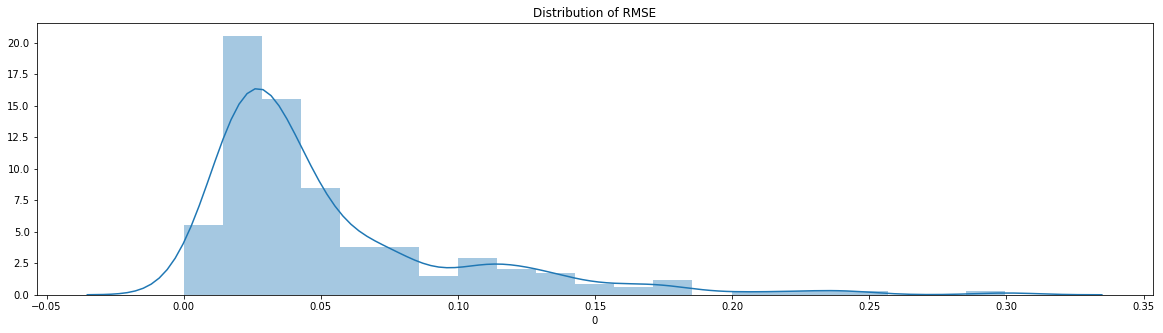

In [104]:
plt.clf()
plt.figure(figsize=(20,5))
plt.title("Distribution of RMSE")
ax = sns.distplot(rmse_benchmark_df[rmse_benchmark_df[0]<0.3][0])
plt.show()

Most of the company RMSE are between 0 and 0.08. The median of it is 0.035409 which is a relative small number. Consensus estimation method is acceptable.

## 1. Baseline: Vector autoregression (VAR)

The most commonly used methods for multivariate time series forecasting is VAR. In this model, each variable is a linear function of the past values of itself and the past values of all the other variables. In this project, VAR is taken as the baseline model. It models the sales growth rate of each company as a stochastic process AR and further captures the dependence structure between different companies. 

In [106]:
# import packages for VAR
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Masking, LSTM
import matplotlib.pyplot as plt
from keras.optimizers import Adam, SGD
from keras import regularizers
from statsmodels.tsa.vector_ar.var_model import VAR
from fancyimpute import IterativeImputer
from utils import dataframe_generate, series_to_supervised

In [116]:
# data preparation for VAR. The logic same as that in missing value part. This cell is prepared to reduce the time from preprating data
df = pd.read_csv('./data/forecasting_dataset.csv')
df['filing_date'] = pd.to_datetime(df['filing_date'],format='%d/%m/%Y')
df['period_end_date'] = pd.to_datetime(df['period_end_date'],format='%d/%m/%Y')
data = df.replace(math.inf, np.nan)
sales_benchmark = []
c_id = sorted(set(data.company_id))

# imputed consensus data
for c in c_id:
    sales_benchmark.append(data[data.company_id == c]['consensus_sales_growth_yoy'].values)
sales_df_benchmark = pd.DataFrame(sales_benchmark).transpose()
sales_df_benchmark.columns = c_id
sales_df_benchmark.index = df[df.company_id==1]['date']
sales_df_benchmark.fillna(0,inplace=True)

sales_df = pd.read_csv('./data/df_imputation_by_lm_daily.csv',index_col=0)
sales_df.columns = [int(x) for x in sales_df.columns]
sales_df_benchmark = sales_df_benchmark[sales_df.columns.tolist()]

# Split to 90/10 train/testing set partition
n_train_days = 1643
train_lm = sales_df.iloc[:n_train_days].values
test_lm = sales_df.iloc[n_train_days:].values

Fit the model with imputed data by linear regression.

In [117]:
var_model_lm = VAR(endog=train)
var_model_fit_lm = var_model_lm.fit()
prediction_lm = var_model_fit_lm.forecast(var_model_fit_lm.y, steps=len(test_lm))

In [118]:
lm_df = pd.DataFrame(prediction_lm)
lm_df.columns = sales_df.columns
lm_df.index = sales_df.index[n_train_days:]
#lm_df.to_csv('var_forecasting_lm.csv')
lm_df.head()

,1,2,3,4,5,6,7,8,9,10,...,238,239,240,241,242,243,244,246,247,248
date,,,,,,,,,,,,,,,,,,,,,
2018-07-02,0.070065,0.027955,0.023656,0.129490,-0.132802,0.079701,0.132986,0.065221,0.151836,0.060666,...,1.055476,-0.198078,-0.070836,0.364438,0.049888,-0.096509,-0.014508,0.436243,-0.010021,0.195888
2018-07-03,0.069638,0.028075,0.023290,0.128684,-0.130443,0.079399,0.132776,0.065725,0.150478,0.064131,...,1.065769,-0.200672,-0.071763,0.363702,0.049959,-0.094317,-0.014461,0.436056,-0.011082,0.200833
2018-07-04,0.069559,0.028262,0.022914,0.128125,-0.128926,0.079034,0.133141,0.066570,0.149760,0.066276,...,1.079725,-0.201799,-0.072573,0.363553,0.049905,-0.093783,-0.014390,0.439754,-0.011873,0.202782
2018-07-05,0.069945,0.028440,0.022412,0.127813,-0.128220,0.078706,0.133879,0.067738,0.149098,0.066339,...,1.089183,-0.201804,-0.072414,0.363680,0.049956,-0.093166,-0.014627,0.444309,-0.012348,0.204027
2018-07-06,0.071230,0.028622,0.022220,0.127672,-0.128101,0.078429,0.134665,0.069042,0.148404,0.065851,...,1.091975,-0.201726,-0.071896,0.363975,0.050127,-0.093022,-0.014689,0.446630,-0.012768,0.204119


Fit the model with imputed data by MICE.

In [120]:
sales_df = pd.read_csv('./data/df_imputation_by_mice_daily.csv',index_col=0)
sales_df.columns = [int(x) for x in sales_df.columns]
sales_df_benchmark = sales_df_benchmark[sales_df.columns.tolist()]
n_train_days = 1643
train = sales_df.iloc[:n_train_days].values
test = sales_df.iloc[n_train_days:].values

var_model = VAR(endog=train)
var_model_fit = var_model.fit()
prediction_mice = var_model_fit.forecast(var_model_fit.y, steps=len(test))

mice_df = pd.DataFrame(prediction_mice)
mice_df.columns = sales_df.columns
mice_df.index = sales_df.index[n_train_days:]
#mice_df.to_csv('var_forecasting_mice.csv')
mice_df.head()

,1,2,3,4,5,6,7,8,9,10,...,238,239,240,241,242,243,244,246,247,248
date,,,,,,,,,,,,,,,,,,,,,
2018-07-02,0.070554,0.027808,0.022677,0.129986,-0.132221,0.079972,0.123835,0.061846,0.150383,0.059208,...,1.030471,-0.216335,-0.076237,0.342743,0.037666,-0.101904,-0.012859,0.427195,-0.013617,0.189091
2018-07-03,0.070993,0.027694,0.022091,0.129333,-0.130170,0.079461,0.129012,0.060318,0.148821,0.063942,...,1.032503,-0.212790,-0.075646,0.353152,0.044766,-0.085845,-0.018669,0.423305,-0.015374,0.195763
2018-07-04,0.072334,0.027907,0.022501,0.128825,-0.129080,0.078965,0.127229,0.060973,0.149030,0.066694,...,1.038050,-0.217214,-0.079785,0.350852,0.043829,-0.097148,-0.019449,0.432900,-0.017667,0.199600
2018-07-05,0.073419,0.027943,0.022530,0.128532,-0.128768,0.078562,0.128879,0.061966,0.147851,0.067930,...,1.043229,-0.213378,-0.077983,0.350268,0.043860,-0.097122,-0.018810,0.436052,-0.019689,0.200213
2018-07-06,0.074830,0.027970,0.022584,0.128361,-0.128664,0.078245,0.129263,0.063029,0.146825,0.067608,...,1.040487,-0.212221,-0.078050,0.350116,0.044028,-0.099093,-0.017759,0.437700,-0.020160,0.202772


In [121]:
benchmark = sales_df_benchmark.iloc[n_train_days:].values
rmse_1_list = []
rmse_2_list = []
rmse_3_list = []
for i in range(test.shape[1]):
    rmse_1 = math.sqrt(mean_squared_error(test[:,i], prediction_lm[:,i]))
    rmse_2 = math.sqrt(mean_squared_error(test[:,i], benchmark[:,i]))
    rmse_3 = math.sqrt(mean_squared_error(test[:,i], prediction_mice[:,i]))
    rmse_1_list.append(rmse_1)
    rmse_2_list.append(rmse_2)
    rmse_3_list.append(rmse_3)
res = {'Company_id':sales_df.columns.tolist(),'VAR_lm':rmse_1_list,'VAR_mice':rmse_3_list,'Benchmark':rmse_2_list}
res = pd.DataFrame(res)
res.head()

,Company_id,VAR_lm,VAR_mice,Benchmark
0,1,0.039220,0.048018,0.024461
1,2,0.007761,0.008708,0.008508
2,3,0.040679,0.043999,0.021603
3,4,0.001778,0.001963,0.012073
4,5,0.120526,0.118614,0.006285


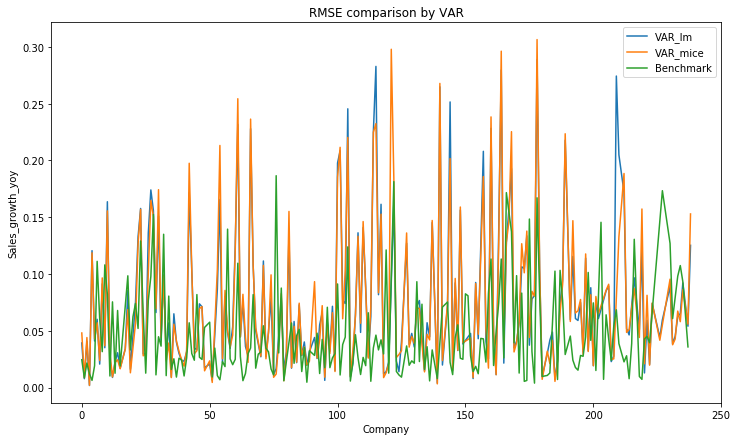

In [132]:
plt.clf()
plt.plot(res[res['VAR_lm']<res['VAR_lm'].quantile(.90)]['VAR_lm'],label='VAR_lm')
plt.plot(res[res['VAR_mice']<res['VAR_mice'].quantile(.90)]['VAR_mice'],label='VAR_mice')
plt.plot(res[res['Benchmark']<res['Benchmark'].quantile(.90)]['Benchmark'],label='Benchmark')

plt.title('RMSE comparison by VAR')
plt.xlabel('Company')
plt.ylabel('Sales_growth_yoy')
plt.legend()
plt.show()

In [124]:
print(sum(res.VAR_lm < res.Benchmark))
print(sum(res.VAR_mice < res.Benchmark))
res.describe()

87
81


,Company_id,VAR_lm,VAR_mice,Benchmark
count,239.000000,239.000000,239.000000,239.000000
mean,123.878661,21.637862,23.380265,10.948611
std,71.784092,330.393803,355.920582,167.741156
min,1.000000,0.001778,0.001963,0.003870
25%,62.500000,0.031511,0.030672,0.019501
50%,124.000000,0.060744,0.060541,0.036448
75%,186.500000,0.133042,0.134624,0.082437
max,248.000000,5107.969847,5502.574404,2593.312050


If the linear regression imputation method is applied, the VAR RMSE is smaller than the benchmark for 87 companies. If the mice imputation method is applied, the VAR RMSE is smaller than the benchmark for 81 companies. However, no matter which imputation method is applied, from the table above we notice the mean and median VAR RMSE are worse than consensus estimators (benchmark).

## 2. LSTM

In this section, we will fit an LSTM to address the problem. Unlike VAR model, the missing values in LSTM are directly replaced by zero and masked in the modeling procedure by adding a masking layer before LSTM layer.

In [134]:
# data preparation
df = pd.read_csv('./data/forecasting_dataset.csv')
df['filing_date'] = pd.to_datetime(df['filing_date'],format='%d/%m/%Y')
df['period_end_date'] = pd.to_datetime(df['period_end_date'],format='%d/%m/%Y')
data = df.replace(math.inf, np.nan)
sales = []
sales_benchmark = []
c_id = sorted(set(data.company_id))
for c in c_id:
    sales.append(data[data.company_id == c]['sales_growth_yoy'].values)
    sales_benchmark.append(data[data.company_id == c]['consensus_sales_growth_yoy'].values)
sales_df = pd.DataFrame(sales).transpose()
sales_df.columns = c_id
sales_df.index = df[df.company_id==1]['date']
sales_df.fillna(0,inplace=True)
sales_df.head()

,1,2,3,4,5,6,7,8,9,10,...,241,242,243,244,245,246,247,248,249,250
date,,,,,,,,,,,,,,,,,,,,,
01/01/2014,0.03503,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.512104,0.079755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02/01/2014,0.03503,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.512104,0.079755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
03/01/2014,0.03503,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.512104,0.079755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
04/01/2014,0.03503,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.512104,0.079755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05/01/2014,0.03503,-0.021529,0.036553,0.074647,-0.034897,0.009554,0.092405,0.023434,-0.143499,0.108803,...,0.512104,0.079755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, all features are normalized and the dataframe is transformed into a supervised learning problem: the target variable is the sales growth for each company in date t while the predictors are sales growth in date t-1. The following example is for company No.15, then its sales growth at t is predicted by the previous values of itself as well as other companies.

In [135]:
values = sales_df.values
values = sales_df.astype('float32')
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed = dataframe_generate(reframed,15)
reframed.fillna(0,inplace=True)
# split into train and test sets
values = reframed.values
reframed.head()

/Users/qinchengwei/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var242(t-1),var243(t-1),var244(t-1),var245(t-1),var246(t-1),var247(t-1),var248(t-1),var249(t-1),var250(t-1),var15(t)
0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.350653
1,0.330929,0.0,0.193485,0.515653,0.684155,0.043102,0.908171,0.171079,0.221445,1.0,...,0.532574,0.911828,0.637757,0.0,0.0,0.084372,0.0,0.0,0.0,0.350653
2,0.330929,0.0,0.193485,0.515653,0.684155,0.043102,0.908171,0.171079,0.221445,1.0,...,0.532574,0.911828,0.637757,0.0,0.0,0.084372,0.0,0.0,0.0,0.350653
3,0.330929,0.0,0.193485,0.515653,0.684155,0.043102,0.908171,0.171079,0.221445,1.0,...,0.532574,0.911828,0.637757,0.0,0.0,0.084372,0.0,0.0,0.0,0.350653
4,0.330929,0.0,0.193485,0.515653,0.684155,0.043102,0.908171,0.171079,0.221445,1.0,...,0.532574,0.911828,0.637757,0.0,0.0,0.084372,0.0,0.0,0.0,0.350653


The first 1643 days are split into the training set which is approximately 90% of the total observations. The testing set contains the last 183 days starting from '2018-07-02'.

In [136]:
n_train_days = 1643
benchmark_y = sales_df_benchmark[15].iloc[n_train_days:].values
values_benchmark = sales_df_benchmark.values
values_benchmark = values_benchmark.astype('float32')
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:,-1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

A LSTM model is proposed with the first layer as a masking layer. Since the missing values are replaced by zero, then the missing values can be ignored by setting the mask value as zero. The LSTM layer contains 50 units with L2 regularization. The optimizer is Adam with learning rate 0.0001. The loss is set as mean squared error. The batch size is 16 and the number of epochs is 16. The plot of training loss vs validation loss is shown below.

In [139]:
# design network
model = Sequential()
model.add(Masking(mask_value=0, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(50, W_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l2(0.01)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0001))

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=16, validation_data=(test_X, test_y), verbose=0)

/Users/qinchengwei/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Update your `LSTM` call to the Keras 2 API: `LSTM(50, activity_regularizer=<keras.reg..., kernel_regularizer=<keras.reg...)`



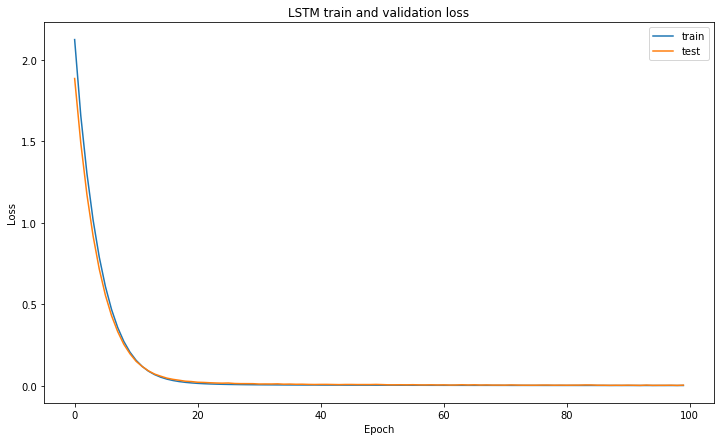

In [178]:
plt.clf()
plt.title('LSTM train and validation loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the graph, the model is shown to be convergent.

In [142]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse_1 = math.sqrt(mean_squared_error(inv_y, inv_yhat))
rmse_2 = math.sqrt(mean_squared_error(inv_y, benchmark_y))
print('LSTM RMSE: %.3f' % rmse_1)
print('Benchmark Test RMSE: %.3f' % rmse_2)

LSTM RMSE: 0.022
Benchmark Test RMSE: 0.079


It can be seen from the output that the LSTM performs much better than the benchmark based on RMSE.

The script for LSTM forecasting 'lstm.py' is run in background since it is time-costly. The two csv files 'lstm_RMSE.csv' contains the RMSE of LSTM method and 'LSTM_forecast.csv' contains the complete sale growth forecasting based on LSTM.

In [147]:
lstm_rmse = pd.read_csv('./data/lstm_RMSE.csv')
lstm_forecast = pd.read_csv('./data/LSTM_forecast.csv',index_col=0)

In [148]:
lstm_rmse.head()

,Company_id,LSTM,Benchmark
0,1,0.022092,0.024461
1,2,0.066200,0.264286
2,3,0.057965,0.117027
3,4,0.044900,0.152589
4,5,0.143777,0.265940


The summary of the LSTM rmse can be decribed as follows.

In [149]:
lstm_rmse.describe()

,Company_id,LSTM,Benchmark
count,250.000000,250.000000,250.000000
mean,125.500000,0.053460,0.187267
std,72.312977,0.042774,0.485099
min,1.000000,0.000013,0.004449
25%,63.250000,0.023339,0.072660
50%,125.500000,0.042210,0.112186
75%,187.750000,0.068022,0.177597
max,250.000000,0.295855,5.565190


In [150]:
sum(lstm_rmse['LSTM']<lstm_rmse['Benchmark'])/len(lstm_rmse.index)

0.836

83.6% of the companies have the LSTM RMSE lower than the benchmark.

## 3. CatBoost

We notice categorical features play a large role in the provided dataset so CatBoost is chosen from the Gradient Boost family. CatBoost has the flexibility of giving indices of categorical columns so that it can be encoded as one-hot encoding using one_hot_max_size (Use one-hot encoding for all features with a number of different values less than or equal to the given parameter value).

In [45]:
# import packages for catboost
from scipy.spatial.distance import euclidean #used for fdt
from sklearn.preprocessing import Imputer
#import fastdtw as fdt #fast dynamic time warping
from statsmodels.tsa.seasonal import seasonal_decompose #decompose seasonality
from statsmodels.tsa.stattools import adfuller #test if series is stationary (then can perform ARIMA)
import xgboost as xgb #xgboost model
# import lightgbm as lgb
from catboost import CatBoostRegressor,Pool
import tensorflow as tf #DNN estimator model
from datetime import date
from sklearn.model_selection import GridSearchCV

###  Feature engineering for catBoost
The target variable is sales_growth_yoy and I selected year, month, company_id, sector_id, sales_growth_yoy, days to next filling date, B1Q_sales, B2Q_sales, B1D_consensus as predictors.

**Year**:Year of the date that the feature values correspond to;

**Month**:Month of the date that the feature values correspond to;

**Company_id, Sector_id**: Company identifier,Sector/Industry identifier;

**Sales_growth_yoy**:Quarterly Sales Growth YoY (current quarter sales / sales of the same quarter 1 year ago);

**Days to next filling date**:days left to next report publish date;

**B1Q_sales, B2Q_sales**: 1 quanter and 2 quanters sales growth rates before current date;

**B1D_consensus**:1 day consensus sales growth rate before current date.

In [48]:
dataf= df.copy()
dataf= dataf.dropna()
# year,month
dataf['year']=pd.DatetimeIndex(dataf['date']).year.astype(int)
dataf['month']=pd.DatetimeIndex(dataf['date']).month.astype(int)
# days to next filling date
dataf['days_to_next_filling_date']=(pd.DatetimeIndex(dataf['filing_date'])-pd.DatetimeIndex(dataf['date'])).days.astype(int)

# sales YoY 1 quarter before this date
B1Q_sales = dataf.loc[:,['date','company_id','sector_id','sales_growth_yoy']]
B1Q_sales['date'] += pd.Timedelta('100 days')
B1Q_sales.columns =['date','company_id','sector_id','B1Q_sales']

dataf = dataf.merge(B1Q_sales, on=['date','company_id','sector_id'])
# sales YoY 2 quarter before this date
B2Q_sales = dataf.loc[:,['date','company_id','sector_id','sales_growth_yoy']]
B2Q_sales['date'] += pd.Timedelta('200 days')
B2Q_sales.columns =['date','company_id','sector_id','B2Q_sales']

dataf = dataf.merge(B2Q_sales, on=['date','company_id','sector_id'])
# consensus_sales one day before this date
B1D_consensus_sales_growth_yoy=dataf.loc[:,['date','company_id','sector_id','consensus_sales_growth_yoy']]
B1D_consensus_sales_growth_yoy['date'] += pd.Timedelta('1 days')
B1D_consensus_sales_growth_yoy.columns =['date','company_id','sector_id','B1D_consensus_sales_growth_yoy']

dataf = dataf.merge(B1D_consensus_sales_growth_yoy, on=['date','company_id','sector_id'])
dataf.head()

,date,company_id,sector_id,sales_growth_yoy,consensus_sales_growth_yoy,filing_date,period_end_date,year,month,days_to_next_filling_date,B1Q_sales,B2Q_sales,B1D_consensus_sales_growth_yoy
0,2014-10-29,1,24,0.044166,0.072380,2015-02-03,2015-01-02,2014,10,97,0.004115,0.022067,0.058917
1,2014-10-29,2,21,0.016050,0.018225,2014-10-29,2014-09-30,2014,10,0,0.015066,-0.003710,0.018225
2,2014-10-29,3,7,0.079689,0.070915,2015-02-11,2014-12-31,2014,10,105,0.046004,0.031774,0.070915
3,2014-10-29,4,6,0.138240,0.136814,2015-01-15,2014-12-31,2014,10,78,0.142575,0.120744,0.136814
4,2014-10-29,5,22,-0.018249,-0.023995,2014-11-03,2014-09-30,2014,10,5,-0.028070,-0.083768,-0.023995


In [50]:
X=dataf.drop(['date','sales_growth_yoy','filing_date', 'period_end_date','consensus_sales_growth_yoy'], axis=1)
y=dataf['sales_growth_yoy']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [51]:
# Prepare Categorical Variables
cate_features_name = ['company_id','sector_id','year','month']
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

categorical_features_pos = column_index(X,cate_features_name)
categorical_features_pos

array([0, 1, 2, 3])

In [52]:
#hyperpara tuning with gridsearch
eval_set = [(x_train, y_train), (x_test, y_test)]

params = {'depth': [5, 12],
         'learning_rate' : [0.25, 0.5],
         'iterations': [5],
         'one_hot_max_size':[300],
         'early_stopping_rounds':[5],
         'od_type':['Iter'],
         }

cb = CatBoostRegressor()
cb_gs_model = GridSearchCV(cb, params, scoring='neg_mean_squared_error',cv = 2)
cb_gs_model.fit(x_train, y_train,
             eval_set=eval_set,
             cat_features=categorical_features_pos,
             use_best_model=True,
             verbose=False)
cb_gs_model.best_params_

{'depth': 12,
 'early_stopping_rounds': 5,
 'iterations': 5,
 'learning_rate': 0.5,
 'od_type': 'Iter',
 'one_hot_max_size': 300}

In [53]:
def cxboost_train(x_train, y_train, x_test,y_test,categorical_features_pos, cb_gs_model):
    """Trains catboost model and returns the model"""
    start = time.time()
    #hyperpara tuning with GridSearch
    eval_set = [(x_train, y_train), (x_test, y_test)]
    cb_model = CatBoostRegressor(depth=12,early_stopping_rounds=5,iterations=500,learning_rate=0.5,od_type='Iter',one_hot_max_size=300,l2_leaf_reg= 9)
    cb_model.fit(x_train, y_train,
             eval_set=eval_set,
             cat_features=categorical_features_pos,
             use_best_model=True,
             verbose=False)

    # retrieve performance metrics
    results = cb_model.get_evals_result()
    epochs = len(results['validation_0']['RMSE'])
    x_axis = range(0, epochs)
    # plot loss
    plt.clf()
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['RMSE'], label='Train')
    ax.plot(x_axis, results['validation_1']['RMSE'], label='Test')
    ax.legend()
    plt.ylabel('RMSE')
    plt.title('CatBoost RMSE')
    plt.show()

    end = time.time()
    print(end - start)
    
    return cb_model

def cxboost_analysis(cb_model, x_train, y_train, x_test,y_test,categorical_features_pos):
    
    print("Catboost RMSE: %f" % np.sqrt(mean_squared_error(y_test, pd.Series(cb_model.predict(x_test)))))
    
    # plot the feature importance
    plt.clf()
    feature_score = pd.DataFrame(list(zip(x_train.dtypes.index, cb_model.get_feature_importance(Pool(x_train, label=y_train, cat_features=categorical_features_pos)))),
                columns=['Feature','Score'])

    feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
    plt.rcParams["figure.figsize"] = (12,7)
    ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
    ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
    ax.set_xlabel('')

    rects = ax.patches

    labels = feature_score['Score'].round(2)

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

    plt.show()

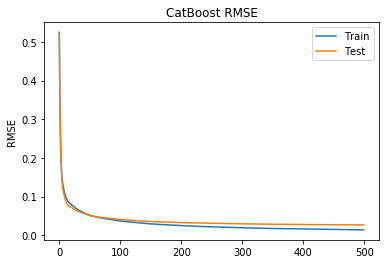

111.89979004859924


In [54]:
cb_model= cxboost_train(x_train, y_train, x_test,y_test,categorical_features_pos, cb_gs_model)

Catboost RMSE: 0.026725
Dataset is provided, but PredictionValuesChange feature importance don't use it, since non-empty LeafWeights in model.


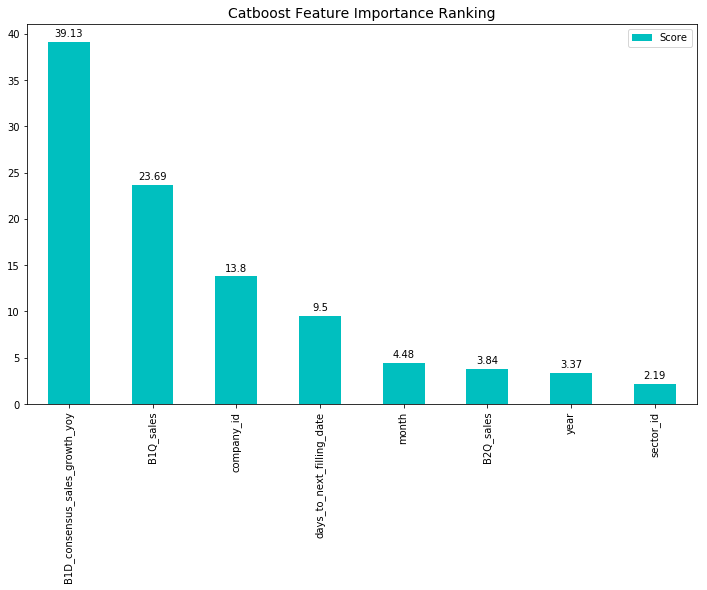

In [55]:
cxboost_analysis(cb_model, x_train, y_train, x_test,y_test,categorical_features_pos)

The RMSE of Catboost on testing set is 0.026725. We could see past data factors influence the results most.

## Comparison

Let's make a comparison between the three methods on the same testing dataset (data after 2018-07-02). Take company 15 as an example.

In [189]:
# to be consistent with VAR and LSTM model, prepare testset for catboost model by selecting all data after 2018-07-02 
# train_cat = sales_df.iloc[:n_train_days].values
test_cat = dataf[dataf['date']>'2018-07-02']
x_test_cat=test_cat.drop(['date','sales_growth_yoy','filing_date', 'period_end_date','consensus_sales_growth_yoy'], axis=1)
y_test_cat=test_cat['sales_growth_yoy']
# predict using the trained model cb_model
test_cat['y_pred']=pd.Series(cb_model.predict(x_test_cat)).values
cb_df=test_cat[['date','company_id','y_pred']].pivot(index='date', columns='company_id', values='y_pred')

cb_df.head()

/Users/qinchengwei/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



company_id,1,2,3,4,5,6,8,9,10,11,...,239,240,241,242,243,244,246,247,248,250
date,,,,,,,,,,,,,,,,,,,,,
2018-07-03,0.057842,0.037509,0.037016,0.134069,-0.123460,0.075070,0.048615,0.151212,0.060258,-0.197931,...,0.154812,0.061101,0.307968,0.039100,-0.055375,0.076931,0.537858,0.111425,NaN,NaN
2018-07-04,0.057709,0.036806,0.037813,0.132764,-0.124163,0.075139,0.048185,0.151212,0.060430,-0.198044,...,0.154474,0.061122,0.307248,0.039053,-0.055713,0.077050,0.538361,0.111292,NaN,NaN
2018-07-05,0.058507,0.035836,0.037813,0.132764,-0.124736,0.075139,0.048250,0.151212,0.060580,-0.197988,...,0.154350,0.060903,0.306460,0.038921,-0.055459,0.077394,0.538284,0.112090,NaN,NaN
2018-07-06,0.058507,0.035836,0.037813,0.131048,-0.124736,0.075275,0.049289,0.151212,0.061677,-0.199789,...,0.154523,0.060200,0.306450,0.039759,-0.055509,0.077466,0.537468,0.112090,NaN,NaN
2018-07-07,0.058507,0.035789,0.037813,0.131821,-0.124784,0.075223,0.049105,0.151161,0.060974,-0.200363,...,0.153820,0.059229,0.306450,0.042340,-0.056752,0.077425,0.537532,0.112090,NaN,NaN


In [228]:
# calculate RMSE for each company
cb_test_actual=test_cat[['date','company_id','sales_growth_yoy']].pivot(index='date', columns='company_id', values='sales_growth_yoy')
cb_rmse={}
for i in cb_test_actual.columns.tolist():
    cb_rmse.setdefault(i-1,np.sqrt(mean_squared_error(cb_test_actual[i].dropna(),cb_df[i].dropna())))
    cb_rmse_df=pd.DataFrame.from_dict(cb_rmse,orient='index')

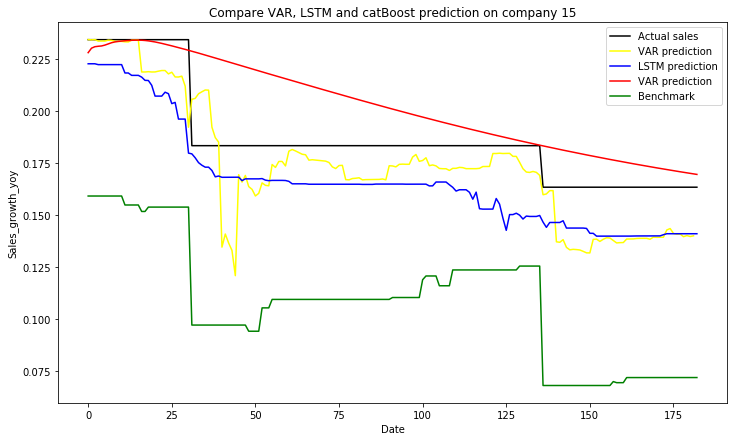

In [192]:
# compare VAR, LSTM and catBoost
plt.clf()
plt.title('Compare VAR, LSTM and catBoost prediction on company 15')
plt.plot(inv_y,'black',label='Actual sales')
plt.plot(cb_df[15].values,'yellow',label='VAR prediction')
plt.plot(inv_yhat,'blue',label='LSTM prediction')
plt.plot(lm_df[15].values,'red',label='VAR prediction')
#plt.plot(mice_df[10].values,'yellow')
plt.plot(benchmark_y,'green',label='Benchmark')
plt.xlabel('Date')
plt.ylabel('Sales_growth_yoy')
plt.legend()
plt.show()

The predictions for company 15 can be visualized as above. The blue line and yellow line are more close to the black line representing the true value than others. LSTM and catBoost perform better than benchmark and VAR model.

Let's compare the RMSE for all companies.

In [226]:
res['LSTM'] = lstm_rmse['LSTM']
res['catBoost']=cb_rmse_df[0]
res.head()

,Company_id,VAR_lm,VAR_mice,Benchmark,LSTM,catBoost
0,1,0.039220,0.048018,0.024461,0.022092,0.011646
1,2,0.007761,0.008708,0.008508,0.066200,0.006561
2,3,0.040679,0.043999,0.021603,0.057965,0.011999
3,4,0.001778,0.001963,0.012073,0.044900,0.007953
4,5,0.120526,0.118614,0.006285,0.143777,0.008765


In [227]:
res.describe()

,Company_id,VAR_lm,VAR_mice,Benchmark,LSTM,catBoost
count,239.000000,239.000000,239.000000,239.000000,239.000000,202.000000
mean,123.878661,21.637862,23.380265,10.948611,0.054915,0.012525
std,71.784092,330.393803,355.920582,167.741156,0.043077,0.005114
min,1.000000,0.001778,0.001963,0.003870,0.000013,0.004328
25%,62.500000,0.031511,0.030672,0.019501,0.024262,0.009222
50%,124.000000,0.060744,0.060541,0.036448,0.044102,0.011525
75%,186.500000,0.133042,0.134624,0.082437,0.068621,0.014652
max,248.000000,5107.969847,5502.574404,2593.312050,0.295855,0.036046


It can be seen from the output that the catBoost performs much better than the benchmark based on RMSE.

Summary:

|                                                     | Consensus | VAR   | LSTM  | catBoost |
| --------------------------------------------------- | --------- | ----- | ----- | -------- |
| Median RMSE                                         | 0.036     | 0.061 | 0.044 | 0.012    |
| No. of companies that RMSE is better than benchmark | NA        | 36.4% | 83.6% | NA       |
| Training time                                       | NA        | Fast  | Long  | Fast     |
| Can handle the missing value in training            | NA        | No    | Yes   | Yes      |



# Prediction

From the analysis above, we choose CatBoost to makes daily predictions for each company for each 'date' in the dataset using imputed input with the trained catBoost model. The result is saved in cb_forecast.csv.

In [288]:
# prepare the input data for catBoost prediction with linear regression imputation
df_imputed=df.copy()

df_imputed['year']=pd.DatetimeIndex(df_imputed['date']).year.astype(int)
df_imputed['month']=pd.DatetimeIndex(df_imputed['date']).month.astype(int)
df_imputed['day']=pd.DatetimeIndex(df_imputed['date']).day.astype(int)

imputed_sales=pd.DataFrame(df_imputation_by_lm_daily.stack()).reset_index()
imputed_sales.columns =['date','company_id','imputed_sales_growth_yoy']
imputed_sales['year']=pd.DatetimeIndex(imputed_sales['date']).year.astype(int)
imputed_sales['month']=pd.DatetimeIndex(imputed_sales['date']).month.astype(int)
imputed_sales['day']=pd.DatetimeIndex(imputed_sales['date']).day.astype(int)

df_imputed = df_imputed.merge(imputed_sales, on=['year','month','day','company_id'])

In [298]:
imputed_c_sales=pd.DataFrame(consensus_df_imputation_by_lm_daily.stack()).reset_index()
imputed_c_sales.columns =['date','company_id','imputed_consensus_sales_growth_yoy']
imputed_c_sales['year']=pd.DatetimeIndex(imputed_c_sales['date']).year.astype(int)
imputed_c_sales['month']=pd.DatetimeIndex(imputed_c_sales['date']).month.astype(int)
imputed_c_sales['day']=pd.DatetimeIndex(imputed_c_sales['date']).day.astype(int)

df_imputed = df_imputed.merge(imputed_c_sales, on=['year','month','day','company_id'])

In [307]:
df_imputed.head()

,date_x,company_id,sector_id,sales_growth_yoy,consensus_sales_growth_yoy,filing_date,period_end_date,year,month,day,date_y,imputed_sales_growth_yoy,date,imputed_consensus_sales_growth_yoy
0,01/01/2014,1,24,0.035030,0.017983,2014-02-04,2014-01-03,2014,1,1,01/01/2014,0.035030,01/01/2014,0.017983
1,01/01/2014,2,21,-0.021529,-0.012229,2014-02-04,2013-12-31,2014,1,1,01/01/2014,-0.021529,01/01/2014,-0.012229
2,01/01/2014,3,7,0.036553,0.040050,2014-02-13,2013-12-31,2014,1,1,01/01/2014,0.036553,01/01/2014,0.040050
3,01/01/2014,4,6,0.074647,0.078425,2014-01-15,2013-12-31,2014,1,1,01/01/2014,0.074647,01/01/2014,0.078425
4,01/01/2014,5,22,-0.034897,-0.030860,2014-02-24,2013-12-31,2014,1,1,01/01/2014,-0.034897,01/01/2014,-0.030860


In [334]:
# Catboost forecast using imputed data
dataf_forecast= df_imputed[['date','year','month','company_id','sector_id','imputed_sales_growth_yoy','imputed_consensus_sales_growth_yoy','filing_date','period_end_date']].copy()
dataf_forecast=dataf_forecast.rename(index=str,columns={'imputed_sales_growth_yoy':'sales_growth_yoy','imputed_consensus_sales_growth_yoy':'consensus_sales_growth_yoy'})
dataf_forecast['date']=pd.to_datetime(dataf_forecast['date'])
# year,month
# dataf_forecast['year']=pd.DatetimeIndex(dataf_forecast['date']).year.astype(int)
# dataf_forecast['month']=pd.DatetimeIndex(dataf_forecast['date']).month.astype(int)
# days to next filling date
nonnull_indx = dataf_forecast[dataf_forecast['filing_date'].notnull()].index
dataf_forecast['days_to_next_filling_date']= np.nan
dataf_forecast['days_to_next_filling_date'][nonnull_indx]=(pd.DatetimeIndex(dataf_forecast['filing_date'][nonnull_indx])-pd.DatetimeIndex(dataf_forecast['date'][nonnull_indx])).days.astype(int)

# sales YoY 1 quarter before this date
B1Q_sales = dataf_forecast.loc[:,['date','company_id','sector_id','sales_growth_yoy']]
B1Q_sales['date'] += pd.Timedelta('100 days')
B1Q_sales.columns =['date','company_id','sector_id','B1Q_sales']

dataf_forecast = dataf_forecast.merge(B1Q_sales, on=['date','company_id','sector_id'])
# sales YoY 2 quarter before this date
B2Q_sales = dataf_forecast.loc[:,['date','company_id','sector_id','sales_growth_yoy']]
B2Q_sales['date'] += pd.Timedelta('200 days')
B2Q_sales.columns =['date','company_id','sector_id','B2Q_sales']

dataf_forecast = dataf_forecast.merge(B2Q_sales, on=['date','company_id','sector_id'])
# consensus_sales one day before this date
B1D_consensus_sales_growth_yoy=dataf_forecast.loc[:,['date','company_id','sector_id','consensus_sales_growth_yoy']]
B1D_consensus_sales_growth_yoy['date'] += pd.Timedelta('1 days')
B1D_consensus_sales_growth_yoy.columns =['date','company_id','sector_id','B1D_consensus_sales_growth_yoy']

dataf_forecast = dataf_forecast.merge(B1D_consensus_sales_growth_yoy, on=['date','company_id','sector_id'])
dataf_forecast.head()

,date,year,month,company_id,sector_id,sales_growth_yoy,consensus_sales_growth_yoy,filing_date,period_end_date,days_to_next_filling_date,B1Q_sales,B2Q_sales,B1D_consensus_sales_growth_yoy
0,2014-11-01,2014,11,1,24,0.035030,0.017983,2014-02-04,2014-01-03,-270.0,0.004115,0.022067,0.071580
1,2014-11-01,2014,11,2,21,-0.021529,-0.013174,2014-02-04,2013-12-31,-270.0,0.015066,-0.003710,0.012842
2,2014-11-01,2014,11,3,7,0.036553,0.040050,2014-02-13,2013-12-31,-261.0,0.072378,0.031774,0.070915
3,2014-11-01,2014,11,4,6,0.074647,0.075410,2014-01-15,2013-12-31,-290.0,0.142575,0.120744,0.136814
4,2014-11-01,2014,11,5,22,-0.034897,-0.030860,2014-02-24,2013-12-31,-250.0,-0.028070,-0.083768,-0.023995


In [338]:
#  fill null value with mean
dataf_forecast['days_to_next_filling_date'][dataf_forecast['days_to_next_filling_date']<0]=0
dataf_forecast['days_to_next_filling_date']=dataf_forecast['days_to_next_filling_date'].fillna(dataf_forecast['days_to_next_filling_date'].mean(skipna=True))

In [339]:
dataf_forecast.head()

,date,year,month,company_id,sector_id,sales_growth_yoy,consensus_sales_growth_yoy,filing_date,period_end_date,days_to_next_filling_date,B1Q_sales,B2Q_sales,B1D_consensus_sales_growth_yoy
0,2014-11-01,2014,11,1,24,0.035030,0.017983,2014-02-04,2014-01-03,0.0,0.004115,0.022067,0.071580
1,2014-11-01,2014,11,2,21,-0.021529,-0.013174,2014-02-04,2013-12-31,0.0,0.015066,-0.003710,0.012842
2,2014-11-01,2014,11,3,7,0.036553,0.040050,2014-02-13,2013-12-31,0.0,0.072378,0.031774,0.070915
3,2014-11-01,2014,11,4,6,0.074647,0.075410,2014-01-15,2013-12-31,0.0,0.142575,0.120744,0.136814
4,2014-11-01,2014,11,5,22,-0.034897,-0.030860,2014-02-24,2013-12-31,0.0,-0.028070,-0.083768,-0.023995


In [340]:
x_forecast=dataf_forecast.drop(['date','sales_growth_yoy','filing_date', 'period_end_date','consensus_sales_growth_yoy'], axis=1)
#predict using the trained model cb_model
dataf_forecast['y_pred']=pd.Series(cb_model.predict(x_forecast)).values

res_df=dataf_forecast[['date','company_id','y_pred']].pivot(index='date', columns='company_id', values='y_pred')
res_df.head()

company_id,1,2,3,4,5,6,7,8,9,10,...,238,239,240,241,242,243,244,246,247,248
date,,,,,,,,,,,,,,,,,,,,,
2014-10-29,0.029489,0.017259,0.076549,0.133299,-0.026807,0.009234,0.090814,0.006765,0.143014,-0.047302,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-30,0.039937,0.009744,0.051175,0.129727,-0.014411,0.013329,0.091538,0.007194,0.107724,0.003506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-10-31,0.037776,0.006754,0.047435,0.129690,-0.013742,0.011819,0.091502,0.005343,0.071315,0.003506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-01,-0.024168,0.015963,0.090331,0.131023,-0.012251,0.014660,0.093303,0.007593,0.088316,-0.013091,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-02,-0.006456,-0.012321,0.052540,0.087531,-0.012699,-0.004004,0.106427,0.031713,-0.211336,-0.035380,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [341]:
res_df.to_csv('./data/cb_forecast.csv')